In [1]:
!pip install transformers plotly==5.8.0 pyyaml==5.4.1 datasets pytorch-lightning > /dev/null 2>&1

In [1]:
from pprint import pprint
import functools
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import pandas as pd

In [2]:
df=pd.read_csv('./dmr2.csv')
df=df[df['count_word']>1]

In [3]:
df.type_level_2.value_counts()

 Autres objets encombrants abandonnés                                                      81085
 Déchets et/ou salissures divers                                                           54590
 Étalages et terrasses à usage commercial                                                  48635
 Graffitis et autocollants sur mur, façade sur rue, pont et descente d'eau pluviale        47328
 Automobile ou autre véhicule motorisé en stationnement gênant                             38662
                                                                                           ...  
 Colonne Morris                                                                               10
 Journal électronique d'information (municipal)                                                8
 Affiches, autocollants ou graffitis sur journal électronique d'information (municipal)        3
 Affiches, autocollants ou graffitis sur panneaux publicitaires (Clear Channel)                3
 Graffitis sur mur, façade sur

In [4]:
count=df.type_level_2.value_counts()

In [5]:
df['occurences']=df['type_level_2'].transform(lambda x: count[x])

In [6]:
df=df[df['occurences']>500]
df=df.drop(columns=['occurences'])

In [7]:
count[count>=500]
 

 Autres objets encombrants abandonnés                                                  81085
 Déchets et/ou salissures divers                                                       54590
 Étalages et terrasses à usage commercial                                              48635
 Graffitis et autocollants sur mur, façade sur rue, pont et descente d'eau pluviale    47328
 Automobile ou autre véhicule motorisé en stationnement gênant                         38662
 Deux-roues motorisé en stationnement gênant                                           12586
 Propreté des équipements de collecte des déchets                                      11859
 Cartons ou sacs de déchets ménagers                                                    9562
 Affiches, autocollants ou graffitis sur mobilier                                       9309
 Gravats ou déchets de chantier                                                         9176
 Protection                                                           

In [8]:
type_level_2=list(set(df['type_level_2']))

In [9]:
dic_niv2={}
for i,tl in enumerate(type_level_2):
    dic_niv2[tl]=i
dic_niv2
df['label']=df['type_level_2'].replace(dic_niv2)


In [10]:
dic_niv2

{' Chariot de supermarché': 0,
 ' Arbre à élaguer': 1,
 ' Arbuste ou jardinière en mauvais état': 2,
 " Graffitis et autocollants sur mur, façade sur rue, pont et descente d'eau pluviale": 3,
 ' Lampadaire en mauvais état': 4,
 ' Autres': 5,
 ' Éclairage public éteint la nuit': 6,
 ' Chaussées': 7,
 ' Affiches, autocollants ou graffitis sur mobilier': 8,
 ' Chantier': 9,
 ' Automobile ou autre véhicule motorisé en stationnement gênant': 10,
 ' Déchets et/ou salissures divers': 11,
 ' Déjections canines': 12,
 ' Peinture sur trottoir': 13,
 ' Gênes à la circulation des piétons': 14,
 ' Nuisances lumineuses': 15,
 ' Marquage au sol  effacé ': 16,
 ' Cartons ou sacs de déchets ménagers': 17,
 ' Feux tricolores ': 18,
 ' Affiches, autocollants ou graffitis sur autres supports': 19,
 ' Objets infestés de punaises de lit': 20,
 ' Mégots': 21,
 ' Propreté des équipements de collecte des déchets': 22,
 ' Trottoirs': 23,
 ' Propreté du sol': 24,
 ' Éclairage public allumé le jour': 25,
 ' Étala

In [11]:
#df=pd.read_csv('./dmr2.csv')

min_count=min(df['type_level_2'].value_counts()) # = 566
balanced_df=df.groupby('type_level_2').apply(lambda x:x.sample(n=min_count,random_state=42)) # 566*58 =32828
df=balanced_df.sample(frac=0.6).reset_index(drop=True) # changer 0.1 par 1 pour avoir les données globale #32828*0.6=
#df=df.sample(frac=0.01).reset_index(drop=True) 
#df1=df1[df1['count_word']>1]

In [12]:
df.count()

creation_date         19697
commentaire_usager    19697
type_level_1          19697
type_level_2          19697
count_word            19697
label                 19697
dtype: int64

In [13]:
min_count

566

In [14]:
from datetime import datetime

In [15]:
df['creation_date'] = pd.to_datetime(df['creation_date'])

# Filtrez les dates entre le 13 juillet et le 19 juillet
start_date = pd.to_datetime('2023-07-14')
end_date = pd.to_datetime('2023-07-20')
filtered_df = df[(df['creation_date'] >= start_date) & (df['creation_date'] <= end_date)]

In [16]:
df=df[df['creation_date'] <start_date]

In [17]:
df

,creation_date,commentaire_usager,type_level_1,type_level_2,count_word,label
0,2022-03-23,bonjour delinquants a nouveau scie barreau ren...,"Arbres, végétaux et animaux",Pelouse en mauvais état,21,45
1,2022-05-13,grille sol detachee,"Arbres, végétaux et animaux",Pied d'arbre,3,39
2,2022-03-16,flaque deau niveau passage pieton,Eau,Accumulation d'eau,5,43
3,2022-04-18,presence bris verre nombreux megots parc a jeux,Propreté,Mégots,8,21
4,2022-12-19,plus dune semaine signalement toujours ramasse...,Propreté,Propreté du sol,25,24
...,...,...,...,...,...,...
19692,2022-09-25,travaux gaz france batiment a labandon depuis ...,Voirie et espace public,Chantier,12,9
19693,2021-07-06,jai deja signale fois depuis mois danger perso...,Voirie et espace public,Trottoirs,16,23
19694,2022-10-05,rue dan sun etat lamentable jonchee detritus t...,Propreté,Déchets et/ou salissures divers,9,11
19695,2022-11-28,crottes chien present tout rue tout temp prevo...,Propreté,Déjections canines,10,12


In [18]:
df['creation_date'].max()

Timestamp('2023-07-13 00:00:00')

In [19]:


# Diviser le DataFrame en ensembles d'entraînement (80%) et de test (20%)
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)

# Diviser l'ensemble de test en ensembles de validation (50%) et de test (50%)
#validation_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Créer un dictionnaire de données pour l'ensemble d'entraînement
train_data = Dataset.from_pandas(train_df)

# Créer un dictionnaire de données pour l'ensemble de validation
validation_data = Dataset.from_pandas(validation_df)

# Créer un dictionnaire de données pour l'ensemble de test
#test_data = Dataset.from_pandas(test_df)

# Créer un DatasetDict en utilisant les divisions d'entraînement, de validation et de test
dataset_dict = DatasetDict({
    'train': train_data,
    'validation': validation_data,
    #'test': test_data
})

dataset = dataset_dict.remove_columns('__index_level_0__')

In [20]:
dataset

DatasetDict({
    train: Dataset({
        features: ['creation_date', 'commentaire_usager', 'type_level_1', 'type_level_2', 'count_word', 'label'],
        num_rows: 15680
    })
    validation: Dataset({
        features: ['creation_date', 'commentaire_usager', 'type_level_1', 'type_level_2', 'count_word', 'label'],
        num_rows: 3921
    })
})

In [21]:
camembert = CamembertForMaskedLM.from_pretrained('camembert-base')

In [22]:
# Visualiser la couches d'embeddings
camembert.roberta.embeddings

CamembertEmbeddings(
  (word_embeddings): Embedding(32005, 768, padding_idx=1)
  (position_embeddings): Embedding(514, 768, padding_idx=1)
  (token_type_embeddings): Embedding(1, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [23]:
# Visualiser les couches cachées
print(f"Camembert est composé de {len(camembert.roberta.encoder.layer)} couches cachées\n")
print("Voilà une couche cachée :")
camembert.roberta.encoder.layer[0]

Camembert est composé de 12 couches cachées

Voilà une couche cachée :


CamembertLayer(
  (attention): CamembertAttention(
    (self): CamembertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): CamembertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): CamembertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): CamembertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [24]:
tokenizer = AutoTokenizer.from_pretrained('camembert-base')


In [25]:
df

,creation_date,commentaire_usager,type_level_1,type_level_2,count_word,label
0,2022-03-23,bonjour delinquants a nouveau scie barreau ren...,"Arbres, végétaux et animaux",Pelouse en mauvais état,21,45
1,2022-05-13,grille sol detachee,"Arbres, végétaux et animaux",Pied d'arbre,3,39
2,2022-03-16,flaque deau niveau passage pieton,Eau,Accumulation d'eau,5,43
3,2022-04-18,presence bris verre nombreux megots parc a jeux,Propreté,Mégots,8,21
4,2022-12-19,plus dune semaine signalement toujours ramasse...,Propreté,Propreté du sol,25,24
...,...,...,...,...,...,...
19692,2022-09-25,travaux gaz france batiment a labandon depuis ...,Voirie et espace public,Chantier,12,9
19693,2021-07-06,jai deja signale fois depuis mois danger perso...,Voirie et espace public,Trottoirs,16,23
19694,2022-10-05,rue dan sun etat lamentable jonchee detritus t...,Propreté,Déchets et/ou salissures divers,9,11
19695,2022-11-28,crottes chien present tout rue tout temp prevo...,Propreté,Déjections canines,10,12


In [26]:
5378/550000

0.009778181818181818

In [27]:
train_df

,creation_date,commentaire_usager,type_level_1,type_level_2,count_word,label
8136,2021-11-30,rue vital rue massenet a h matin eclairage pub...,Éclairage / Électricité,Éclairage public allumé le jour,10,25
16232,2022-07-29,eau coupe tous limmeuble suite a travaux voie ...,Eau,Autres problèmes d'eau,11,41
6425,2021-12-20,epanchement durine odeur forte,Propreté,Épanchement d'urine,4,46
3448,2021-07-15,velo quj na bouge depuis annees,"Autos, motos, vélos...",Épave de vélo,6,30
16768,2022-03-21,plan vigipirate non respecte devant misee quai...,"Autos, motos, vélos...",Épave de trottinette,22,51
...,...,...,...,...,...,...
11342,2021-08-18,presence dun corbeau mort belle taille place l...,"Arbres, végétaux et animaux",Autres problèmes d'animaux et d'insectes,13,34
12022,2022-02-16,sortie impossible,"Autos, motos, vélos...",Deux-roues motorisé en stationnement gênant,2,55
5413,2023-01-29,avaloir obstrue risque dinondation chaussee a ...,Voirie et espace public,Trappes ou grilles au sol,8,28
862,2022-03-28,face lebouis,"Graffitis, tags, affiches et autocollants","Affiches, autocollants ou graffitis sur mobilier",2,8


In [28]:
nb_labels = len(train_df["label"].unique())


In [29]:
nb_labels

58

In [30]:
train_df['label'].value_counts()

9     296
6     295
23    291
25    286
12    286
30    286
3     283
34    283
36    282
0     282
17    282
15    281
13    281
7     281
24    280
2     279
22    278
42    278
47    278
37    277
43    276
18    275
10    274
54    274
35    273
39    273
52    271
16    271
56    271
50    271
28    271
46    270
51    270
21    270
14    270
8     269
44    269
40    267
32    267
31    263
41    262
27    261
55    260
29    260
38    260
5     258
1     257
57    256
49    256
19    255
33    255
11    255
53    253
26    252
45    252
48    250
4     250
20    248
Name: label, dtype: int64

/tmp/ipykernel_1684389/3888794055.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax.figure.show()


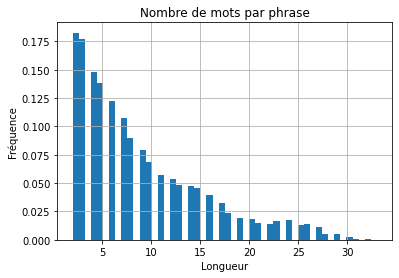

In [31]:
ax = train_df["count_word"].hist(density=True, bins=50)
ax.set_xlabel("Longueur")
ax.set_ylabel("Fréquence")
ax.set_title("Nombre de mots par phrase")
ax.figure.show()

/tmp/ipykernel_1684389/2121024345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["len_utt"] = train_df["commentaire_usager"].apply(lambda x: len(x))
/tmp/ipykernel_1684389/2121024345.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax.figure.show()


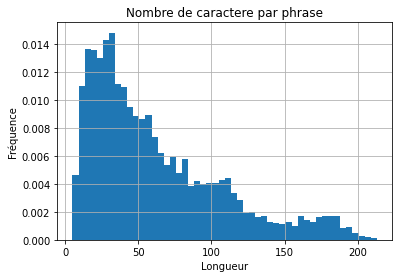

In [32]:
train_df["len_utt"] = train_df["commentaire_usager"].apply(lambda x: len(x))
ax = train_df["len_utt"].hist(density=True, bins=50)
ax.set_xlabel("Longueur")
ax.set_ylabel("Fréquence")
ax.set_title("Nombre de caractere par phrase")
ax.figure.show()

In [33]:
(train_df["len_utt"] > 512).any()

False

In [34]:
5000/550000

0.00909090909090909

In [35]:
def tokenize_batch(samples, tokenizer):
    text = [sample["commentaire_usager"] for sample in samples]
    labels = torch.tensor([sample["label"] for sample in samples])
    str_labels = [sample["type_level_2"] for sample in samples]
 
    tokens = tokenizer(text, padding="longest", return_tensors="pt")

    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask, "labels": labels, "str_labels": str_labels, "sentences": text}

In [36]:
train_dataset, val_dataset = dataset.values()

In [37]:
val_dataloader = DataLoader(val_dataset, collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer), batch_size=16)
next(iter(val_dataloader))

{'input_ids': tensor([[    5,   245,  8299,  2247,     8,   276,  9709,  2232, 13429, 11192,
           4783,  8798,  4229,  1120,  2277,  1126,  1222,     8,   216,   483,
              6,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1],
         [    5,  5061,  9635, 14639,  7215,   839,    21, 24073,   252,  5081,
            117, 29525,    10,   839,    21, 24073,   252,     6,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1],
         [    5,  6688,  7830,   185,     8,  4665,   744,    10,  1024,     6,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1],
         [    5,    66,    46,    73,   616,    90,  1293,    21,  3089,   762,
              6,     1,     

In [38]:
num_labels=58

In [39]:
dataset["train"]

Dataset({
    features: ['creation_date', 'commentaire_usager', 'type_level_1', 'type_level_2', 'count_word', 'label'],
    num_rows: 15680
})

In [40]:
train_dataloader = DataLoader(
    dataset["train"],
    batch_size=16,
    shuffle=True,
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)
val_dataloader = DataLoader(
    dataset["validation"],
    batch_size=16,
    shuffle=False,
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)
'''
test_dataloader = DataLoader(
    dataset["test"],
    batch_size=16,
    shuffle=False,
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)'''

'\ntest_dataloader = DataLoader(\n    dataset["test"],\n    batch_size=16,\n    shuffle=False,\n    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)\n)'

In [41]:
batch = next(iter(train_dataloader))

In [42]:
print("\n".join(tokenizer.batch_decode(batch["input_ids"])))
batch["labels"]

<s> cest quand</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<s> forte odeur urine</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<s> vegetaux piquants debordants message protege</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<s> bonjour merci personnes viennent nettoyer cette partie rue jet karcher parle daccord cest tellement sale quil faudrait brosser produit special car jet cela nettoie</s>
<s> feu ba mal oriente</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<s> trottoir face numero</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<s> revetement degrade fissure</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

tensor([13, 46,  2, 14, 18, 29, 23, 46, 34, 32,  5, 51, 51,  6, 29, 18])

In [43]:
class LightningModel(pl.LightningModule):
    def __init__(self, model_name, num_labels, lr, weight_decay, from_scratch=False):
        super().__init__()
        self.save_hyperparameters()
        if from_scratch:
            # Si `from_scratch` est vrai, on charge uniquement la config (nombre de couches, hidden size, etc.) et pas les poids du modèle
            config = AutoConfig.from_pretrained(
                model_name, num_labels=num_labels
            )
            self.model = AutoModelForSequenceClassification.from_config(config)
        else:
            # Cette méthode permet de télécharger le bon modèle pré-entraîné directement depuis le Hub de HuggingFace sur lequel sont stockés de nombreux modèles
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels
            )
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_labels = self.model.num_labels

    def forward(self, batch):
        return self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

    def training_step(self, batch):
        out = self.forward(batch)

        logits = out.logits
        # -------- MASKED --------
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, self.num_labels), batch["labels"].view(-1))

        # ------ END MASKED ------

        self.log("train/loss", loss)

        return loss

    def validation_step(self, batch, batch_index):
        labels = batch["labels"]
        out = self.forward(batch)

        preds = torch.max(out.logits, -1).indices
        # -------- MASKED --------
        acc = (batch["labels"] == preds).float().mean()
        # ------ END MASKED ------
        self.log("valid/acc", acc)

        f1 = f1_score(batch["labels"].cpu().tolist(), preds.cpu().tolist(), average="macro")
        self.log("valid/f1", f1)

    def predict_step(self, batch, batch_idx):
        """La fonction predict step facilite la prédiction de données. Elle est
        similaire à `validation_step`, sans le calcul des métriques.
        """
        out = self.forward(batch)

        return torch.max(out.logits, -1).indices

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

In [44]:
lightning_model = LightningModel("camembert-base", num_labels, lr=3e-5, weight_decay=0.)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bia

In [45]:
## Lancer l'entraînement
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor="valid/acc", mode="max")

camembert_trainer = pl.Trainer(
    max_epochs=20,

    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid/acc", patience=4, mode="max"),
        model_checkpoint,
    ]
)

/home/pc/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/pc/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:651: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/pc/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


In [66]:
import torch
print(torch.cuda.is_available())

True


In [69]:
device='cuda'


In [ ]:
import time

t0 = time.time()
camembert_trainer.fit(lightning_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
t1 = time.time()

total = t1-t0
print(total)


  | Name  | Type                               | Params
-------------------------------------------------------------
0 | model | CamembertForSequenceClassification | 110 M 
-------------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.666   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/pc/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/pc/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/pc/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on

Training: 0it [00:00, ?it/s]

In [40]:
lightning_model = LightningModel.load_from_checkpoint(checkpoint_path=model_checkpoint.best_model_path)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.wei

In [ ]:
#lightning_model = LightningModel.load_from_checkpoint(checkpoint_path='/home/jovyan/work/Classification_txt_dmr/lightning_logs/version_4/checkpoints/epoch=0-step=1617.ckpt')

In [43]:
model_checkpoint.best_model_path

'/home/jovyan/work/Classification_txt_dmr/lightning_logs/version_4/checkpoints/epoch=0-step=1617.ckpt'

In [ ]:
lightning_model.eval()

In [ ]:
len(df)

In [41]:
camembert_trainer.validate(lightning_model, dataloaders=val_dataloader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        valid/acc           0.7971552014350891
        valid/f1            0.7309389201390849
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'valid/acc': 0.7971552014350891, 'valid/f1': 0.7309389201390849}]

In [42]:
camembert_trainer.validate(lightning_model, dataloaders=test_dataloader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        valid/acc           0.7971552014350891
        valid/f1            0.7206385308652883
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'valid/acc': 0.7971552014350891, 'valid/f1': 0.7206385308652883}]

In [70]:
ID_TO_LABEL=list(dic_niv2.keys())

In [130]:
def get_preds(model, tokenizer, sentence):
    tokenized_sentence = tokenizer(sentence, return_tensors="pt")
    input_ids, attention_mask = tokenized_sentence.input_ids, tokenized_sentence.attention_mask

    out = model(
        input_ids=tokenized_sentence.input_ids,
        attention_mask=tokenized_sentence.attention_mask
    )

    logits = out.logits

    probas = torch.softmax(logits, -1).squeeze()

    pred = torch.argmax(probas)

    return ID_TO_LABEL[pred], probas[pred].item()

In [72]:
device=torch.device('cpu')


In [86]:
df['commentaire_usager'][1]

'administree signale aire jeux situe square niveau tres dangereux sagit dun escalier colimacon acceder toboggan non proteger garde corp poignet casse merci'

In [87]:
df['type_level_2'][1]

'Mobiliers urbains'

In [88]:
Model=lightning_model.model

In [89]:
test_sentence = df['commentaire_usager'][1]

label_predicted, proba = get_preds(Model.to(device), tokenizer, test_sentence)

print(f"Label: {label_predicted}, confidence: {proba:.2f}")

Label: Mobiliers urbains, confidence: 0.47


In [138]:
camembert_preds = camembert_trainer.predict(lightning_model, dataloaders=val_dataloader)
camembert_preds = torch.cat(camembert_preds, -1)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [135]:
label_names = ID_TO_LABEL
labels = dataset["validation"]["label"]

In [139]:
def plot_confusion_matrix(labels, preds, label_names):
    confusion_norm = confusion_matrix(labels, preds.tolist(), labels=list(range(len(label_names))), normalize="true")
    confusion = confusion_matrix(labels, preds.tolist(), labels=list(range(len(label_names))))

    plt.figure(figsize=(10, 10))
    sns.heatmap(
        confusion_norm,
        annot=confusion,
        cbar=False,
        fmt="d",
        xticklabels=label_names,
        yticklabels=label_names,
        cmap="viridis"
    )

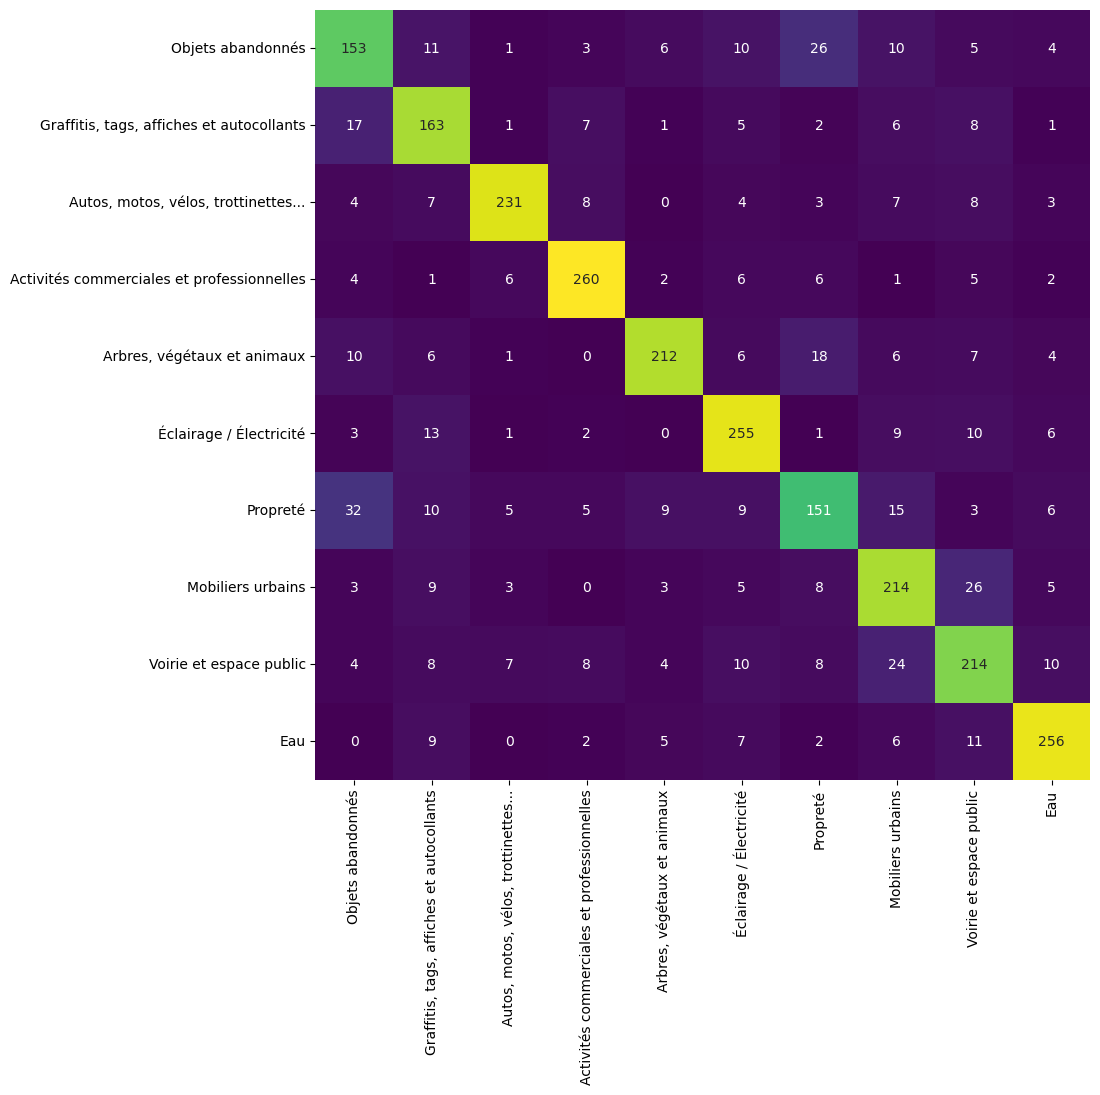

In [140]:
plot_confusion_matrix(labels, camembert_preds, label_names)